In [1]:
'''------------SECTION IMPORTS---------------------'''
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score

# next command ensures that plots appear inside the notebook
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # also improves the look of plots
sns.set()  # set Seaborn defaults
plt.rcParams['figure.figsize'] = [10, 5]  # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed after import seaborn

# reveal a hint only while holding the mouse down
from IPython.display import HTML
HTML("<style>.h,.c{display:none}.t{color:#296eaa}.t:active+.h{display:block;}</style>")

# hide FutureWarnings, which may show for Seaborn calls in most recent Anaconda
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [109]:
'''------------SECTION USER VARIABLES--------------'''
#Define the path to your datafolder below
your_datapath = "C:/Users/20203668/Downloads/data_and_model DC3/data_and_model/"

#Define search space for number of trees in random forest and depth of trees
num_trees_min = 64
num_trees_max = 128

depth_min = 2
depth_max = 7

In [110]:
#Function that creates a pandas dataframe for a single district with columns for the baseline model with semiyearly entries
def make_district_df_semiyearly(datapath, district_name):
    """
    Function that creates a pandas dataframe for a single district with columns for the baseline model with semiyearly entries

    Parameters
    ----------
    datapath : string
        Path to the datafolder
    district_name : string
        Name of the district

    Returns
    -------
    df : pandas dataframe
    """

	#Read all relevant datasets
    prevalence_df = pd.read_csv(datapath + 'prevalence_estimates.csv', parse_dates=['date'])
    covid_df = pd.read_csv(datapath + 'covid.csv', parse_dates=['date'])
    ipc_df = pd.read_csv(datapath + 'ipc2.csv', parse_dates=['date'])
    risk_df = pd.read_csv(datapath + 'FSNAU_riskfactors.csv', parse_dates=['date'])
    production_df = pd.read_csv(datapath + 'production.csv', parse_dates=['date'])
    
    #Select data for specific district
    prevalence_df = prevalence_df[prevalence_df['district']==district_name]
    ipc_df = ipc_df[ipc_df['district']==district_name]
    risk_df = risk_df[risk_df['district']==district_name]
    production_df = production_df[production_df['district']==district_name]

    risk_df = risk_df.groupby(pd.Grouper(key='date', freq='6M')).mean()
    risk_df = risk_df.reset_index()
    risk_df['date'] = risk_df['date'].apply(lambda x : x.replace(day=1))
    
    covid_df = covid_df.groupby(pd.Grouper(key='date', freq='6M')).sum()
    covid_df = covid_df.reset_index()
    covid_df['date'] = covid_df['date'].apply(lambda x : x.replace(day=1))
    
    production_df['cropdiv'] = production_df.count(axis=1)
    
    #Sort dataframes on date
    prevalence_df.sort_values('date', inplace=True)
    covid_df.sort_values('date', inplace=True)
    ipc_df.sort_values('date', inplace=True)
    risk_df.sort_values('date', inplace=True)
    production_df.sort_values('date', inplace=True)

    #Merge dataframes, only joining on current or previous dates as to prevent data leakage
    df = pd.merge_asof(left=prevalence_df, right=ipc_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=production_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=risk_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=covid_df, direction='backward', on='date')
    
    #Calculate prevalence 6lag
    df['prevalence_6lag'] = df['GAM Prevalence'].shift(1)
    df['next_prevalence'] = df['GAM Prevalence'].shift(-1)
    
    #Select needed columns
    df = df[['date', 'district', 'GAM Prevalence', 'next_prevalence', 'prevalence_6lag', 'new_cases', 'ndvi_score', 'phase3plus_perc', 'cropdiv', 'total population']]
    df.columns = ['date', 'district', 'prevalence', 'next_prevalence', 'prevalence_6lag', 'covid', 'ndvi', 'ipc', 'cropdiv', 'population']
    
    #Add month column
    df['month'] = df['date'].dt.month
    
    #Add target variable: increase for next month prevalence (boolean)
    increase = [False if x[1]<x[0] else True for x in list(zip(df['prevalence'], df['prevalence'][1:]))]
    increase.append(False)
    df['increase'] = increase
    df.iloc[-1, df.columns.get_loc('increase')] = np.nan #No info on next month
    
    #Add target variable: increase for next month prevalence (boolean)
    increase_numeric = [x[1] - x[0] for x in list(zip(df['prevalence'], df['prevalence'][1:]))]
    increase_numeric.append(0)
    df['increase_numeric'] = increase_numeric
    df.iloc[-1, df.columns.get_loc('increase_numeric')] = np.nan #No info on next month
    
    df.loc[(df.date < pd.to_datetime('2020-03-01')), 'covid'] = 0
    
    return(df)

In [111]:
#Function that combines the semiyearly dataset (from the function make_district_df_semiyearly) of all districts
def make_combined_df_semiyearly(datapath):
    """
    Function that creates a pandas dataframe for all districts with columns for the baseline model with semiyearly entries

    Parameters
    ----------
    datapath : string
        Path to the datafolder

    Returns
    -------
    df : pandas dataframe
    """

    prevdf = pd.read_csv(datapath + 'prevalence_estimates.csv', parse_dates=['date'])
    districts = prevdf['district'].unique()
    
    df_list = []
    for district in districts:
        district_df = make_district_df_semiyearly(datapath, district)
        district_df['district'] = district
        df_list.append(district_df)
        
    df = pd.concat(df_list, ignore_index=True)
    df['district_encoded'] = df['district'].astype('category').cat.codes

    return df

In [112]:
#Function that returns every possible subset (except the empty set) of the input list l
def subsets (l):
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list


In [135]:
'''------------SECTION DATAFRAME CREATION--------------'''
#Create the dataframe for all districts
df = make_combined_df_semiyearly(your_datapath)

#Drop every row with missing values
df.dropna(inplace=True)

#Sort dataframe on date and reset the index
df.sort_values('date', inplace=True)
df.reset_index(inplace=True, drop=True)

#Drop disctricts with less than 7 observations: 'Burco', 'Saakow', 'Rab Dhuure', 'Baydhaba', 'Afmadow'
df.drop(df[df['district'].isin(['Burco', 'Saakow', 'Rab Dhuure', 'Baydhaba', 'Afmadow'])].index, inplace=True)

In [136]:
#Data Analysis

In [137]:
df

,date,district,prevalence,next_prevalence,prevalence_6lag,covid,ndvi,ipc,cropdiv,population,month,increase,increase_numeric,district_encoded
0,2018-01-01,Afgooye,0.351000,0.384859,0.369200,0.0,0.273333,0.00,6.0,309683.385,1,True,0.033859,3
1,2018-01-01,Gebiley,0.197600,0.244319,0.338000,0.0,0.208333,0.13,2.0,146038.500,1,True,0.046719,51
2,2018-01-01,Kurtunwaarey,0.351000,0.446118,0.369200,0.0,0.365000,0.18,5.0,95730.255,1,True,0.095118,61
3,2018-01-01,Qansax Dheere,0.288600,0.509285,0.358800,0.0,0.266667,0.09,7.0,123818.085,1,True,0.220685,71
4,2018-01-01,Waajid,0.486200,0.474895,0.486200,0.0,0.250000,0.11,5.0,85276.755,1,False,-0.011305,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2021-01-01,Hargeysa,0.196585,0.267635,0.127787,3583.0,0.200000,0.12,2.0,1044086.000,1,True,0.071050,52
244,2021-01-01,Baraawe,0.491189,0.465542,0.450524,3583.0,0.421667,0.06,5.0,56743.000,1,False,-0.025647,14
245,2021-01-01,Sheikh,0.182837,0.224277,0.145549,3583.0,0.260000,0.18,2.0,71387.000,1,True,0.041440,78
246,2021-01-01,Bulo Burto,0.198074,0.346220,0.455601,3583.0,0.366667,0.12,10.0,90880.000,1,True,0.148145,25


In [116]:
df_grouped = df.groupby(['date', 'district']).mean()
df_matrix = df_grouped["prevalence"].unstack()
df_matrix

df_grouped2 = df.groupby(['district', 'date']).mean()
df_matrix2 = df_grouped2["prevalence"].unstack()

df_grouped6 = df.groupby(['date', 'district']).mean()
df_matrix6 = df_grouped6["prevalence_6lag"].unstack()
df_matrix6

district,Afgooye,Baardheere,Badhaadhe,Balcad,Baraawe,Belet Weyne,Borama,Bu'aale,Bulo Burto,Cadale,...,Marka,Owdweyne,Qansax Dheere,Qoryooley,Sablaale,Sheikh,Tayeeglow,Waajid,Xarardheere,Xudur
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.369200,0.431600,0.431600,0.369200,0.369200,0.429000,0.379600,0.431600,0.429000,0.369200,...,0.369200,0.340600,0.358800,0.369200,0.369200,0.340600,0.486200,0.486200,0.473200,0.486200
2018-07-01,0.351000,0.392600,0.392600,0.351000,0.351000,0.392600,0.169000,0.392600,0.392600,0.351000,...,0.351000,0.202800,0.288600,0.351000,0.351000,0.202800,0.486200,0.486200,0.400400,0.486200
2019-01-01,0.384859,0.297261,0.371119,0.358041,0.378577,0.463728,0.240625,0.412518,0.390895,0.282920,...,0.397141,0.230342,0.509285,0.436380,0.430961,0.250586,0.350261,0.474895,0.344711,0.468902
2019-07-01,0.438340,0.287088,0.233031,0.425632,0.439932,0.470948,0.204456,0.318316,0.470453,0.397643,...,0.435675,0.207294,0.470640,0.438857,0.436521,0.252666,0.473194,0.479289,0.344094,0.481612
2020-01-01,0.462159,0.521397,0.482359,0.420789,0.468040,0.586805,0.273633,0.516375,0.589845,0.336884,...,0.453959,0.331082,0.549068,0.464707,0.457822,0.311808,0.548118,0.545855,0.239552,0.545779
2020-07-01,0.449223,0.248437,0.348957,0.389925,0.445483,0.495492,0.213871,0.399468,0.479814,0.308362,...,0.463714,0.216355,0.648001,0.444339,0.458776,0.208140,0.518512,0.531234,0.396278,0.549549
2021-01-01,0.458235,0.230484,0.263954,0.399241,0.450524,0.462584,0.141288,0.411806,0.455601,0.290517,...,0.490504,0.132174,0.424443,0.480135,0.493320,0.145549,0.411714,0.436723,0.392585,0.446990


In [117]:
list(df_matrix.columns.values)

['Afgooye',
 'Baardheere',
 'Badhaadhe',
 'Balcad',
 'Baraawe',
 'Belet Weyne',
 'Borama',
 "Bu'aale",
 'Bulo Burto',
 'Cadale',
 'Ceel Dheer',
 'Diinsoor',
 'Doolow',
 'Gebiley',
 'Hargeysa',
 'Hobyo',
 'Jalalaqsi',
 'Jamaame',
 'Jilib',
 'Jowhar',
 'Kismaayo',
 'Kurtunwaarey',
 'Luuq',
 'Marka',
 'Owdweyne',
 'Qansax Dheere',
 'Qoryooley',
 'Sablaale',
 'Sheikh',
 'Tayeeglow',
 'Waajid',
 'Xarardheere',
 'Xudur']

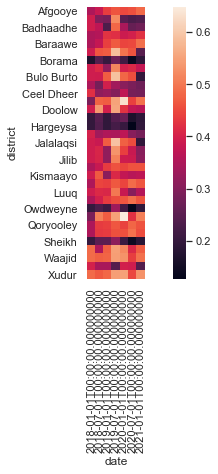

In [118]:
sns.heatmap(data=df_matrix2, square=True);


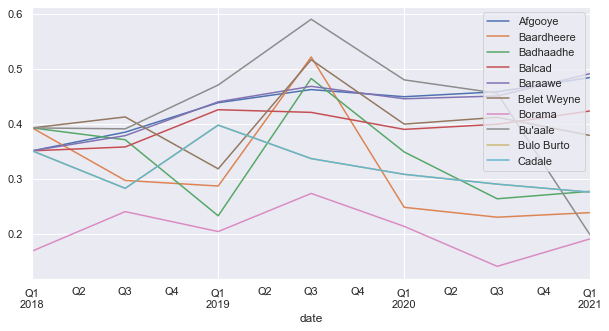

In [119]:
ax_combined = df_matrix['Afgooye'].plot()
ax_combined = df_matrix['Baardheere'].plot()
ax_combined = df_matrix['Badhaadhe'].plot()
ax_combined = df_matrix['Balcad'].plot()
ax_combined = df_matrix['Baraawe'].plot()
ax_combined = df_matrix["Bu'aale"].plot()
ax_combined = df_matrix['Borama'].plot()
ax_combined = df_matrix['Bulo Burto'].plot()
ax_combined = df_matrix['Cadale'].plot()
df_matrix['Cadale'].plot(ax=ax_combined)
ax_combined.legend(['Afgooye','Baardheere','Badhaadhe','Balcad','Baraawe','Belet Weyne','Borama',"Bu'aale",'Bulo Burto','Cadale',]);

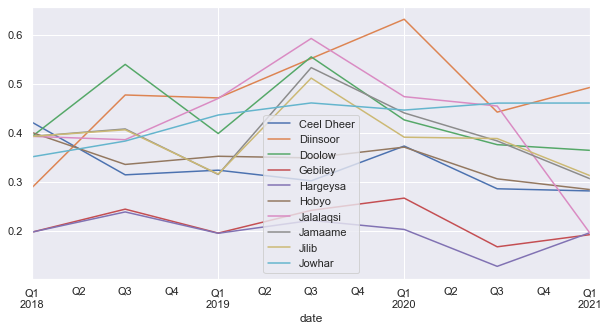

In [120]:
ax_combined = df_matrix['Ceel Dheer'].plot()
ax_combined = df_matrix['Diinsoor'].plot()
ax_combined = df_matrix['Doolow'].plot()
ax_combined = df_matrix['Gebiley'].plot()
ax_combined = df_matrix['Hargeysa'].plot()
ax_combined = df_matrix['Hobyo'].plot()
ax_combined = df_matrix['Jalalaqsi'].plot()
ax_combined = df_matrix['Jamaame'].plot()
ax_combined = df_matrix['Jilib'].plot()
df_matrix['Jowhar'].plot(ax=ax_combined)
ax_combined.legend(['Ceel Dheer',
 'Diinsoor',
 'Doolow',
 'Gebiley',
 'Hargeysa',
 'Hobyo',
 'Jalalaqsi',
 'Jamaame',
 'Jilib',
 'Jowhar'])

NameError: name 'df_matrixn' is not defined

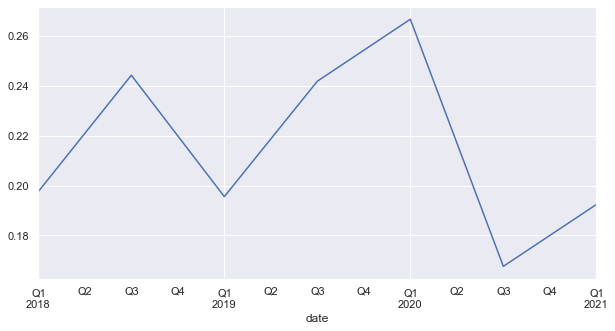

In [121]:
ax_combined = df_matrix['Gebiley'].plot()
df_matrixn['Gebiley'].plot(ax=ax_combined)
ax_combined.legend(['prevalence',
 'next prevalence'])

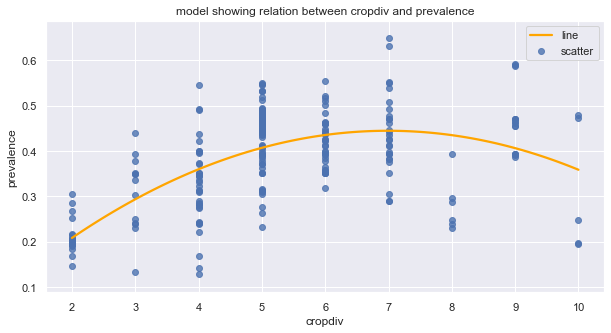

In [122]:
ax = sns.regplot(df['cropdiv'], df['prevalence'], line_kws={'color':'orange'}, ci=None, order=2);
ax.legend(['line', 'scatter'])
ax.set_title("model showing relation between cropdiv and prevalence");

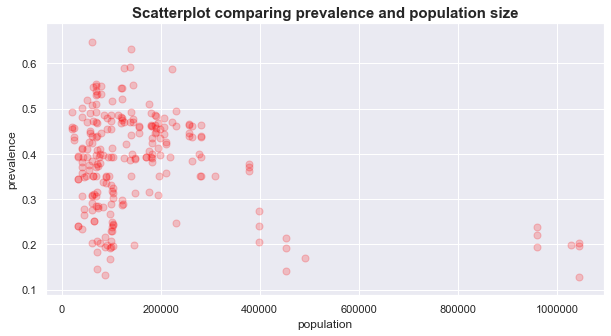

In [123]:
ax = df.plot(kind='scatter', x='population', y='prevalence', s=50, c='red', alpha=0.2);
ax.set_title("Scatterplot comparing prevalence and population size", size = 15, weight = 'bold');

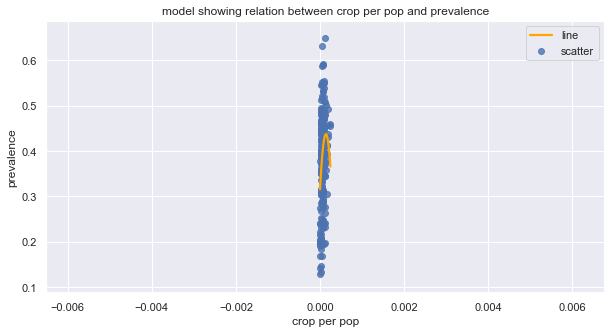

In [139]:
df['crop per pop'] = df['cropdiv']/df['population']

ax = sns.regplot(df['crop per pop'], df['prevalence'], line_kws={'color':'orange'}, ci=None, order=2);
ax.legend(['line', 'scatter'])
ax.set_title("model showing relation between crop per pop and prevalence");

In [1]:
#Analyse new data set

In [ ]:
#Get mean amount of rain for two time periods (dates of 01-01 & 07-01 (contains total rain of 6 previous months))

In [45]:
meanrain = pd.read_csv('rainfall 2000-2022.csv')

In [46]:
meanrain['time'] = pd.to_datetime(meanrain['time'])

In [47]:
meanrain['year'] = meanrain['time'].dt.year
meanrain['month'] = meanrain['time'].dt.month
meanrain.head()

,time,rfe,rfe_filled,year,month
0,2000-01-01,-999.0,0.03,2000,1
1,2000-01-02,-999.0,0.09,2000,1
2,2000-01-03,-999.0,0.48,2000,1
3,2000-01-04,-999.0,0.13,2000,1
4,2000-01-05,-999.0,0.04,2000,1


In [81]:
meanrain_first = meanrain[meanrain['month'] < 7]
meanrain_first['date'] = 'placeholder'
for i in meanrain_first.index:
    year = meanrain_first['year'][i]
    year_str = str(year)
    meanrain_first['date'][i] = year_str + '-07-01' #contains data from 6 months previous to the date
meanrain_first['day'] = '07-01'
meanrain_first

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

,time,rfe,rfe_filled,year,month,date,day
0,2000-01-01,-999.00,0.03,2000,1,2000-07-01,07-01
1,2000-01-02,-999.00,0.09,2000,1,2000-07-01,07-01
2,2000-01-03,-999.00,0.48,2000,1,2000-07-01,07-01
3,2000-01-04,-999.00,0.13,2000,1,2000-07-01,07-01
4,2000-01-05,-999.00,0.04,2000,1,2000-07-01,07-01
...,...,...,...,...,...,...,...
8212,2022-06-26,0.04,0.04,2022,6,2022-07-01,07-01
8213,2022-06-27,0.28,0.28,2022,6,2022-07-01,07-01
8214,2022-06-28,0.73,0.73,2022,6,2022-07-01,07-01
8215,2022-06-29,1.04,1.04,2022,6,2022-07-01,07-01


In [83]:
meanrain_second = meanrain[meanrain['month'] >= 7]
meanrain_second['date'] = 'placeholder'
for i in meanrain_second.index:
    meanrain_second['year'][i] = meanrain_second['year'][i] + 1 #because it's the last six months, the date for which it is combined is the 1st day of the next year
    year = meanrain_second['year'][i]
    year_str = str(year)
    meanrain_second['date'][i] = year_str + '-01-01' #contains data from 6 months previous to the date
meanrain_second['day'] = '01-01'
meanrain_second

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i

,time,rfe,rfe_filled,year,month,date,day
182,2000-07-01,0.00,0.00,2001,7,2001-01-01,01-01
183,2000-07-02,0.00,0.00,2001,7,2001-01-01,01-01
184,2000-07-03,0.00,0.00,2001,7,2001-01-01,01-01
185,2000-07-04,0.01,0.01,2001,7,2001-01-01,01-01
186,2000-07-05,0.05,0.05,2001,7,2001-01-01,01-01
...,...,...,...,...,...,...,...
8299,2022-09-21,0.14,0.14,2023,9,2023-01-01,01-01
8300,2022-09-22,0.06,0.06,2023,9,2023-01-01,01-01
8301,2022-09-23,0.04,0.04,2023,9,2023-01-01,01-01
8302,2022-09-24,0.01,0.01,2023,9,2023-01-01,01-01


In [84]:
meanrain_combined = pd.concat([meanrain_first, meanrain_second], sort=False)
meanrain_combined

,time,rfe,rfe_filled,year,month,date,day
0,2000-01-01,-999.00,0.03,2000,1,2000-07-01,07-01
1,2000-01-02,-999.00,0.09,2000,1,2000-07-01,07-01
2,2000-01-03,-999.00,0.48,2000,1,2000-07-01,07-01
3,2000-01-04,-999.00,0.13,2000,1,2000-07-01,07-01
4,2000-01-05,-999.00,0.04,2000,1,2000-07-01,07-01
...,...,...,...,...,...,...,...
8299,2022-09-21,0.14,0.14,2023,9,2023-01-01,01-01
8300,2022-09-22,0.06,0.06,2023,9,2023-01-01,01-01
8301,2022-09-23,0.04,0.04,2023,9,2023-01-01,01-01
8302,2022-09-24,0.01,0.01,2023,9,2023-01-01,01-01


In [85]:
meanrain_grouped = meanrain_combined. groupby(['day', 'year']).agg({'rfe_filled':['sum']})
meanrain_grouped.columns = ['total_meanrain']
meanrain_0101 = meanrain_grouped[:22] #years 2001-2022 for 01-01 dates (2023 removed as it is not the full 6 months)
meanrain_0101

total_meanrain
day   year                
01-01 2001           69.52
      2002           76.10
      2003           69.00
      2004           41.46
      2005           89.82
      2006          104.74
      2007          167.98
      2008          102.54
      2009           75.08
      2010          122.77
      2011           77.99
      2012          175.77
      2013          106.36
      2014           44.32
      2015          426.57
      2016           62.97
      2017          143.40
      2018          152.54
      2019           93.76
      2020          162.17
      2021          100.99
      2022          179.52

In [86]:
meanrain_0701 = meanrain_grouped[23:] #years 2000-2022 for 07-01 dates
meanrain_0701

total_meanrain
day   year                
07-01 2000          120.14
      2001           96.28
      2002          204.27
      2003          170.85
      2004          208.21
      2005          162.94
      2006          154.38
      2007          224.75
      2008          199.14
      2009          114.50
      2010          142.56
      2011          151.99
      2012          129.98
      2013          142.59
      2014          263.83
      2015          151.22
      2016          108.46
      2017          101.42
      2018          109.22
      2019          137.43
      2020          186.94
      2021          114.93
      2022          176.33

In [87]:
meanrain_0101['total_meanrain'].mean() #120.24

120.2440909090909

In [88]:
meanrain_0701['total_meanrain'].mean() #155.32

155.31999999999996

In [95]:
rainfall_grouped = meanrain_combined. groupby(['date']).agg({'rfe_filled':['sum']})
rainfall_grouped.columns = ['total_rainfall']
rainfall_grouped = rainfall_grouped[35:42] #between 2018-01-01 & 2021-01-01
rainfall_grouped

,total_rainfall
date,
2018-01-01,152.54
2018-07-01,109.22
2019-01-01,93.76
2019-07-01,137.43
2020-01-01,162.17
2020-07-01,186.94
2021-01-01,100.99


In [96]:
#fill the mean and the total rainfall in the dataframe for random forest input

In [141]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.head()

,date,district,prevalence,next_prevalence,prevalence_6lag,covid,ndvi,ipc,cropdiv,population,month,increase,increase_numeric,district_encoded,crop per pop,year
0,2018-01-01,Afgooye,0.3510,0.384859,0.3692,0.0,0.273333,0.00,6.0,309683.385,1,True,0.033859,3,0.000019,2018
1,2018-01-01,Gebiley,0.1976,0.244319,0.3380,0.0,0.208333,0.13,2.0,146038.500,1,True,0.046719,51,0.000014,2018
2,2018-01-01,Kurtunwaarey,0.3510,0.446118,0.3692,0.0,0.365000,0.18,5.0,95730.255,1,True,0.095118,61,0.000052,2018
3,2018-01-01,Qansax Dheere,0.2886,0.509285,0.3588,0.0,0.266667,0.09,7.0,123818.085,1,True,0.220685,71,0.000057,2018
4,2018-01-01,Waajid,0.4862,0.474895,0.4862,0.0,0.250000,0.11,5.0,85276.755,1,False,-0.011305,81,0.000059,2018


In [165]:
df['total_rainfall'] = 0.0 #placeholder
df['mean_rainfall'] = 0.0 # placeholder
df['difference_rainfall'] = 0.0 #placeholder
df['more_rainfall'] = True #True if there is more rainfall than mean,False if there is less rainfall than mean
for i in df.index:
    if (df['year'][i] == 2018) == True:
        if (df['month'][i] == 1) == True:
            df['total_rainfall'][i] = 152.54
            df['mean_rainfall'][i] = 120.24
            df['difference_rainfall'][i] = 32.30
        if (df['month'][i] == 7) == True:
            df['total_rainfall'][i] = 109.22
            df['mean_rainfall'][i] = 155.32
            df['difference_rainfall'][i] = -46.10
            df['more_rainfall'][i] = False
    if (df['year'][i] == 2019) == True:
        if (df['month'][i] == 1) == True:
            df['total_rainfall'][i] = 93.76
            df['mean_rainfall'][i] = 120.24
            df['difference_rainfall'][i] = -26.48
            df['more_rainfall'][i] = False
        if (df['month'][i] == 7) == True:
            df['total_rainfall'][i] = 137.43
            df['mean_rainfall'][i] = 155.32
            df['difference_rainfall'][i] = -17.89
            df['more_rainfall'][i] = False
    if (df['year'][i] == 2020) == True:
        if (df['month'][i] == 1) == True:
            df['total_rainfall'][i] = 162.17
            df['mean_rainfall'][i] = 120.24
            df['difference_rainfall'][i] = 41.93
        if (df['month'][i] == 7) == True:
            df['total_rainfall'][i] = 186.94
            df['mean_rainfall'][i] = 155.32
            df['difference_rainfall'][i] = 31.62
    if (df['year'][i] == 2021) == True:
        df['total_rainfall'][i] = 100.99
        df['mean_rainfall'][i] = 120.24
        df['difference_rainfall'][i] = -19.25
        df['more_rainfall'][i] = False
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\A

In [168]:
df.drop(['year', 'month'], axis=1, inplace=True)
df

,date,district,prevalence,next_prevalence,prevalence_6lag,covid,ndvi,ipc,cropdiv,population,increase,increase_numeric,district_encoded,crop per pop,total_rainfall,mean_rainfall,difference_rainfall,more_rainfall
0,2018-01-01,Afgooye,0.351000,0.384859,0.369200,0.0,0.273333,0.00,6.0,309683.385,True,0.033859,3,0.000019,152.54,120.24,32.30,True
1,2018-01-01,Gebiley,0.197600,0.244319,0.338000,0.0,0.208333,0.13,2.0,146038.500,True,0.046719,51,0.000014,152.54,120.24,32.30,True
2,2018-01-01,Kurtunwaarey,0.351000,0.446118,0.369200,0.0,0.365000,0.18,5.0,95730.255,True,0.095118,61,0.000052,152.54,120.24,32.30,True
3,2018-01-01,Qansax Dheere,0.288600,0.509285,0.358800,0.0,0.266667,0.09,7.0,123818.085,True,0.220685,71,0.000057,152.54,120.24,32.30,True
4,2018-01-01,Waajid,0.486200,0.474895,0.486200,0.0,0.250000,0.11,5.0,85276.755,False,-0.011305,81,0.000059,152.54,120.24,32.30,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2021-01-01,Hargeysa,0.196585,0.267635,0.127787,3583.0,0.200000,0.12,2.0,1044086.000,True,0.071050,52,0.000002,100.99,120.24,-19.25,False
244,2021-01-01,Baraawe,0.491189,0.465542,0.450524,3583.0,0.421667,0.06,5.0,56743.000,False,-0.025647,14,0.000088,100.99,120.24,-19.25,False
245,2021-01-01,Sheikh,0.182837,0.224277,0.145549,3583.0,0.260000,0.18,2.0,71387.000,True,0.041440,78,0.000028,100.99,120.24,-19.25,False
246,2021-01-01,Bulo Burto,0.198074,0.346220,0.455601,3583.0,0.366667,0.12,10.0,90880.000,True,0.148145,25,0.000110,100.99,120.24,-19.25,False


In [169]:
'''------------SECTION RANDOM FOREST CROSS VALIDATION--------------'''
#WARNING: this process can take some time, since there are a lot of hyperparameters to investigate. The search space can be manually reduced to speed up the process.

#Create empty list to store model scores
parameter_scores = []

#Define target and explanatory variables
X = df.drop(columns = ['increase', 'increase_numeric', 'date', 'district', 'prevalence', 'next_prevalence']) #Note that these columns are dropped, the remaining columns are used as explanatory variables
y = df['next_prevalence'].values

for num_trees in range(num_trees_min, num_trees_max):
    
    for depth in range(depth_min, depth_max):
        
        #Investigate every subset of explanatory variables
        for features in subsets(X.columns):
        
            #First CV split. The 99 refers to the first 3 observations for the 33 districts in the data.
            Xtrain = X[:99][features].copy().values
            ytrain = y[:99]
            Xtest = X[99:132][features].copy().values
            ytest = y[99:132]

            #Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0)

            #Fit to the training data
            clf.fit(Xtrain, ytrain)

            #Make a prediction on the test data
            predictions = clf.predict(Xtest)

            #Calculate mean absolute error
            MAE1 = mean_absolute_error(ytest, predictions)


            #Second CV split. The 132 refers to the first 4 observations for the 33 districts in the data.
            Xtrain = X[:132][features].copy().values
            ytrain = y[:132]
            Xtest = X[132:165][features].copy().values
            ytest = y[132:165]

            #Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0)

            #Fit to the training data
            clf.fit(Xtrain, ytrain)

            #Make a prediction on the test data
            predictions = clf.predict(Xtest)

            #Calculate mean absolute error
            MAE2 = mean_absolute_error(ytest, predictions)

            #Calculate the mean MAE over the two folds
            mean_MAE = (MAE1 + MAE2)/2

            #Store the mean MAE together with the used hyperparameters in list 
            parameter_scores.append((mean_MAE, num_trees, depth, features))


In [170]:
#Sort the models based on score and retrieve the hyperparameters of the best model
parameter_scores.sort(key=lambda x: x[0])
best_model_score = parameter_scores[0][0]
best_model_trees = parameter_scores[0][1]
best_model_depth = parameter_scores[0][2]
best_model_columns = list(parameter_scores[0][3])



In [171]:
'''------------SECTION FINAL EVALUATION--------------'''
X = df[best_model_columns].values
y = df['next_prevalence'].values

#If there is only one explanatory variable, the values need to be reshaped for the model
if len(best_model_columns) == 1:
	X = X.reshape(-1, 1)

#Peform evaluation on full data
Xtrain = X[:165]
ytrain = y[:165]
Xtest = X[165:]
ytest = y[165:]

clf = RandomForestRegressor(n_estimators=best_model_trees, max_depth=best_model_depth, random_state=0)
clf.fit(Xtrain, ytrain)
predictions = clf.predict(Xtest)

#Calculate MAE
MAE = mean_absolute_error(ytest, predictions)

#Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
increase           = [0 if x<y else 1 for x in df.iloc[165:]['next_prevalence'] for y in df.iloc[165:]['prevalence']]
predicted_increase = [0 if x<y else 1 for x in predictions                      for y in df.iloc[165:]['prevalence']]

#Calculate accuracy of predicted boolean increase/decrease
acc = accuracy_score(increase, predicted_increase)

#Print model parameters
print('no. of trees: ' + str(best_model_trees) + '\nmax_depth: ' + str(best_model_depth) + '\ncolumns: ' + str(best_model_columns))

#Print model scores
print(MAE, acc)

no. of trees: 74
max_depth: 6
columns: ['district_encoded']
0.05629900026844118 0.849862258953168
